# End-to-end Demo US Tweet Sentiment

1. Demo US Tweets Sentiment Analysis Map introduction
The dataset is used to train is sentiment140 dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.

Sentiment Analysis is contextual mining of text which identifies and extracts subjective information in source material, and helping a business to understand the social sentiment of their brand, product or service while monitoring online conversations.

Amended from US Tweets Sentiment Analysis Map

2. Import dependencies

In [1]:
%%sh
conda install basemap

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.9.0
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda




In [2]:
#Hack to fix missing PROJ4 env var
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
# system
import os
import warnings
import sys
    
# utilities
import numpy as np
import warnings
import pandas
import string
import re
import numpy
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import time
import gc
%matplotlib inline

# plotting
import matplotlib.pyplot as plt
import seaborn
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
#models

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from collections import Counter

#mlflow 
import mlflow
import mlflow.sklearn
import logging

warnings.filterwarnings("ignore")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def clear_sentence(sentence: str) -> str:
    sentence = sentence.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    sentence = sentence.lower()
    #sentence = remove_stopword(sentence)
    return sentence

In [9]:
def word_cloud_plot(data):
    wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data))
    plt.figure(figsize = (20,20))
    plt.imshow(wc)

In [ ]:
3. Read training data, understand data and clean data¶
Load the sentiment140 dataset and take a look at how tweet datasets usually look like

(1600000, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
read_train_data method info
Lets look at the distribution of tweets in the train set


<AxesSubplot:xlabel='target', ylabel='count'>

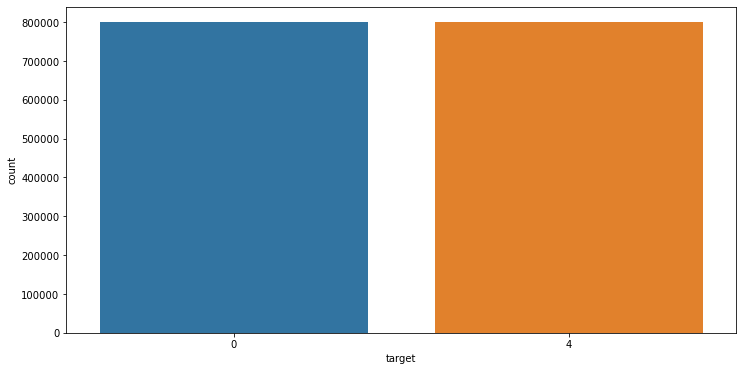

In [4]:
# Load the data and take a look at how tweet datasets usually look like
Sentiments = pandas.read_csv('./data/training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", names=["target", "ids", "date", "flag", "user", "text"])
    
print(Sentiments.shape)
Sentiments.head(10)
Sentiments.info()
Sentiments.describe()
    
# Now, we only use text and the sentiment field for training. 
Sentiments = Sentiments[['target','text']]
print('read_train_data method info') 
    
# Make the sentiments strings
sentiment_value = {0: "negative", 2: "neutral", 4: "positive"}
decode = lambda label: sentiment_value[int(label)]
x = Sentiments['text'].apply(clear_sentence).tolist()
y = Sentiments['target'].apply(decode).tolist()
    
print('Lets look at the distribution of tweets in the train set')
temp = Sentiments.groupby('target').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')
    
# plot the train data
plt.figure(figsize=(12,6))
seaborn.countplot(x='target',data=Sentiments)


4. Train model using LinearSVC and log model to MLFlow

In [5]:
def train_our_model_in_tweets(x,y):
    # mlflow logging
    logging.basicConfig(level=logging.WARN)
    logger = logging.getLogger(__name__)
    
    # Let's use the SVC model.
    starting_time = time.time()   
    vector = TfidfVectorizer(ngram_range=(1, 2))
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    X_training = vector.fit_transform(X_train) 
    X_testing = vector.transform(X_test)

    
    # Useful for multiple runs (only doing one run in this sample notebook)    
    with mlflow.start_run():
        
        model = LinearSVC()
        model.fit(X_training, y_train)
        y_prediction = model.predict(X_testing)
        accuracy = accuracy_score(y_test, y_prediction)
        ending_time = time.time()
        print('Trained our model in',len(Sentiments.index),'tweets')
        print('Accuracy:',"{:.2f}".format(accuracy*100) + " in {:.2f}s".format(ending_time-starting_time))
        
        #logging metric to mlflow
        mlflow.log_metric("No. records", len(Sentiments.index))
        mlflow.log_metric("Accuracy", accuracy*100)
        mlflow.log_metric("Time", ending_time-starting_time)
        
        mlflow.sklearn.log_model(model, "model")
        return model,vector

In [6]:
 # A function to get only the data inside the USA (there are many tweets from abroad)
def get_region(data, bot_lat, top_lat, left_lon, right_lon):
        top = data.lat <= top_lat
        bot = data.lat >= bot_lat
        left = data.long >= left_lon
        right = data.long <= right_lon
        index = top&bot&left&right 
        return data[index]

4. Apply the model to real data

In [7]:
def plot_support(model,vector):
   # 1. read real data
    # Get the dataset
    Trump = pandas.read_csv('./data/hashtag_donaldtrump.csv', lineterminator='\n')
    Biden = pandas.read_csv('./data/hashtag_joebiden.csv', lineterminator='\n')
   
    Trump = Trump[['tweet','lat','long']]
    Biden = Biden[['tweet','lat','long']]

    # And let's clean our reviews
    Trump['tweet'] = Trump['tweet'].dropna().apply(clear_sentence)
    Biden['tweet'] = Biden['tweet'].dropna().apply(clear_sentence)

    # A function to get only the data inside the USA (there are many tweets from abroad)
    def get_region(data, bot_lat, top_lat, left_lon, right_lon):
        top = data.lat <= top_lat
        bot = data.lat >= bot_lat
        left = data.long >= left_lon
        right = data.long <= right_lon
        index = top&bot&left&right 
        return data[index]

    Trump = get_region(Trump,24,50,-126,-65)
    Biden = get_region(Biden,24,50,-126,-65)
    
    print("Word cloud for Trump")
    word_cloud_plot(Trump)
    
    print("Word cloud for Biden")
    word_cloud_plot(Biden)
    
    # apply model to get predict sentiment analytic

    trump_sentiment = pandas.DataFrame(model.predict(vector.transform(Trump['tweet'].tolist())),columns=['sentiment'])
    biden_sentiment = pandas.DataFrame(model.predict(vector.transform(Biden['tweet'].tolist())),columns=['sentiment'])

    Trump = pandas.concat([Trump.reset_index(drop=True), trump_sentiment], axis=1)
    Biden = pandas.concat([Biden.reset_index(drop=True), biden_sentiment], axis=1)

    trump_positive = Trump[Trump['sentiment'] == 'positive']
    biden_positive = Biden[Biden['sentiment'] == 'positive']

    Map = Basemap(llcrnrlat=24,urcrnrlat=50,llcrnrlon=-126,urcrnrlon=-65)
    plt.figure(figsize=(12,10))
    Map.bluemarble(alpha=0.6)

    seaborn.scatterplot(x='long', y='lat', data=biden_positive, linewidth=0, s=40, alpha=1, label='Support for Biden')
    seaborn.scatterplot(x='long', y='lat', data=trump_positive, linewidth=0, s=40, alpha=0.01, label='Support for Trump')

    plt.gca().get_legend().legendHandles[1].set_alpha(1)
    plt.title("Tweets positive towards presidential candidates")
    plt.show()

Trained our model in 1600000 tweets
Accuracy: 82.33 in 298.42s
Word cloud for Trump
Word cloud for Biden


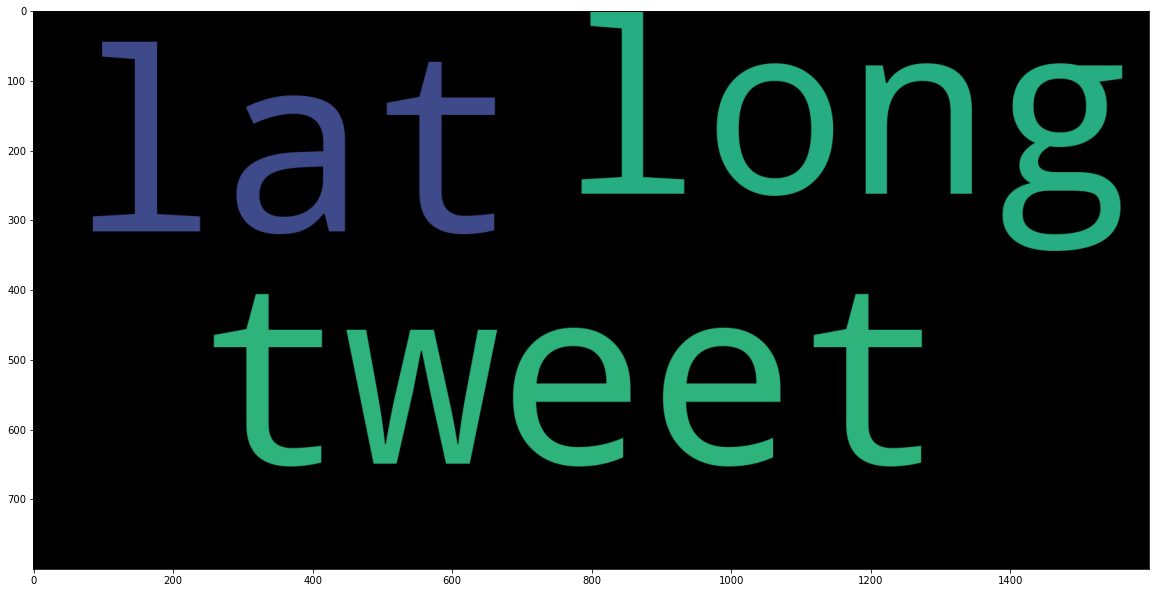

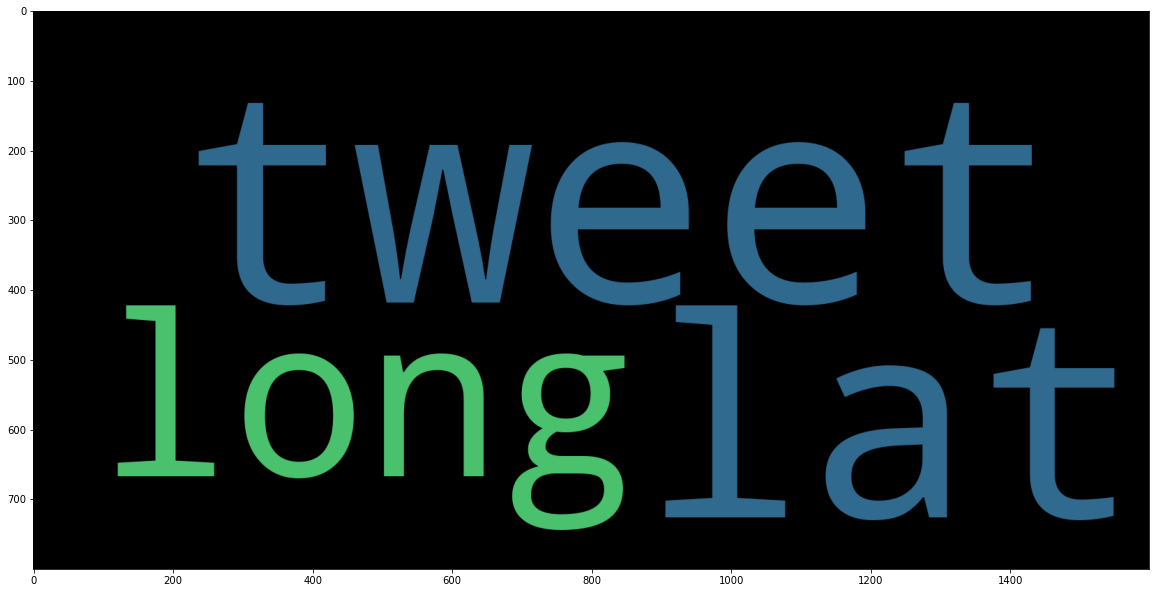

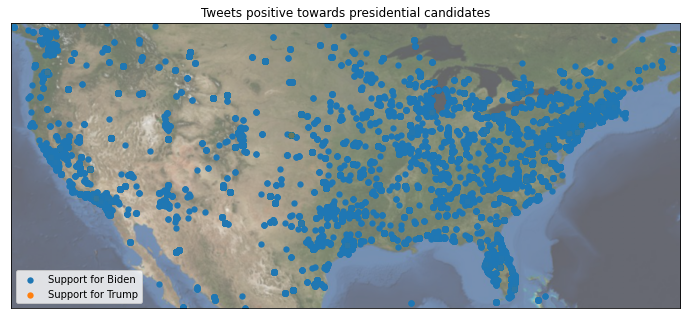

In [10]:
trained_model,fitted_vector = train_our_model_in_tweets(x,y)
plot_support(trained_model,fitted_vector)